# Machine Learning Estimation of Time-Varying Price Impact
## Extending the Cont-Kukanov-Stoikov Model with Random Forest

**MSCF 46982 Market Microstructure and Algorithmic Trading**

In [ ]:
# Initialize Environment
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx

PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


In [2]:
%%q
\c 25 200
/ Connect to NYSE TAQ kdb+ server
home:`HOME`USERPROFILE "w"=first string .z.o
upf:` sv (hsym`$getenv home),`cmu_userpass.txt
h:`$":tcps://tpr-mscf-kx.tepper.cmu.edu:5000:",first read0 upf

In [3]:
%%py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

plt.style.use('default')
mpl.rcParams["figure.figsize"] = [12, 5]
mpl.rcParams["font.size"] = 11

## Feature Engineering with kdb/Q

We use kdb/Q to compute microstructure features efficiently:
1. Order Flow Imbalance calculation
2. Market depth and spread computation
3. Realized volatility estimation
4. Feature aggregation by time bucket

In [4]:
%%q

/ Define the complete feature extraction function
extract_features:{[bucket;syms;dt]
 / Order Flow Imbalance (OFI) - Cont et al. (2012)
 ofi:{[b;bs;a;as]
  e:bs*b>=pb:prev[first b;b];
  e-:prev[first bs;bs]*b<=pb;
  e-:as*a<=pa:prev[first a;a];
  e+:prev[first as;as]*a>=pa;
  e};
 
 / Query NBBO data within regular trading hours
 t:select time,sym,bid,ask,bsize,asize from nbbo 
   where date=dt, sym in syms, time within 0D10 0D15:30, asize>0, bsize>0;
 
 / Compute mid price and OFI at tick level by symbol
 t:update mid:0.5*bid+ask, spread:ask-bid from t;
 t:update ofi_val:ofi[bid;bsize;ask;asize] by sym from t;
 
 / Aggregate by time bucket and symbol
 agg:select 
   open_mid:first mid,
   close_mid:last mid,
   high_mid:max mid,
   low_mid:min mid,
   ofi:sum ofi_val,
   avg_depth:avg 0.5*bsize+asize,
   bid_depth:avg bsize,
   ask_depth:avg asize,
   avg_spread:avg spread,
   n_updates:count i
 by sym, bucket xbar time from t;
 
 / Compute derived features
 agg:update 
   dprice:100*(close_mid-open_mid),
   volatility:sqrt (1f%4f*log 2f) * avg xexp[;2] log high_mid%low_mid,
   depth_imbalance:(bid_depth-ask_depth)%(bid_depth+ask_depth),
   rel_spread:avg_spread%close_mid
 from agg;
 
 / Compute price impact coefficient (when OFI is significant)
 agg:update beta:?[abs[ofi]>100;dprice%ofi;0n] from agg;
 
 / Remove key for easier handling
 0!agg}

In [5]:
%%q
/ DATA EXTRACTION - Multiple symbols, single day

syms:`AAPL`MSFT`AMZN`GOOG`META`TSLA`NVDA
bucket:0D00:00:10  / 10-second buckets for more observations
dt:2020.02.03

/ Extract features - send function to remote server
features:h (extract_features;bucket;syms;dt)

/ Display results
5#features

sym  time                 open_mid close_mid high_mid low_mid ofi avg_depth bid_depth ask_depth avg_spread n_updates dprice volatility   depth_imbalance rel_spread   beta      
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
AAPL 0D10:00:00.000000000 310.78   311.295   311.445  310.78  650 21.85302  2.988447  40.71759  0.07813864 779       51.5   0.0004945629 -0.8632479      0.0002510115 0.07923077
AAPL 0D10:00:10.000000000 311.295  311.195   311.295  310.92  57  2.811526  2.836449  2.786604  0.07660436 642       -10    0.0004945629 0.008864266     0.0002461619           
AAPL 0D10:00:20.000000000 311.215  311.31    311.33   311.185 42  2.312278  2.825623  1.798932  0.08724199 562       9.5    0.0004945629 0.2220085       0.0002802415           
AAPL 0D10:00:30.000000000 311.31   311.16    311.31   311.04  106 4.413956  4.500525  4.327387  0.08247639 953     

In [6]:
%%q
/ ADDITIONAL FEATURE ENGINEERING (Local computation)

/ Add lagged features by symbol (for avoiding look-ahead bias)
features:update lag_ofi:prev ofi, lag_depth:prev avg_depth, lag_spread:prev avg_spread, lag_vol:prev volatility, lag_beta:prev beta, lag_dprice:prev dprice by sym from features

/ Add rolling features (5-period lookback)
features:update roll_ofi_mean:mavg[5;ofi], roll_vol_mean:mavg[5;volatility], roll_depth_mean:mavg[5;avg_depth] by sym from features

/ Filter valid observations
features:select from features where not null lag_ofi, not null beta, not null roll_ofi_mean, volatility > 0

In [7]:
%%q
/ Transfer data to Python
.pykx.set[`df] .pykx.topd features

## Model Implementation

### Data Preparation

We prepare the data for modeling:
- **Target variable:** Price impact coefficient $\beta_t$
- **Features:** Lagged market state variables (to avoid look-ahead bias)
- **Validation:** TimeSeriesSplit for proper time-series cross-validation

In [8]:
%%py

# Get data from kdb+
df = kx.q('features').pd()

print(f"Dataset shape: {df.shape}")
print(f"\nSymbols: {df['sym'].unique()}")
print(f"\nFeature statistics:")
df.describe().round(4)

Dataset shape: (1310, 26)

Symbols: ['AAPL' 'AMZN' 'GOOG' 'MSFT' 'NVDA' 'TSLA']

Feature statistics:


,time,open_mid,close_mid,high_mid,low_mid,ofi,avg_depth,bid_depth,ask_depth,avg_spread,...,beta,lag_ofi,lag_depth,lag_spread,lag_vol,lag_beta,lag_dprice,roll_ofi_mean,roll_vol_mean,roll_depth_mean
count,1310,1310.0000,1310.0000,1310.0000,1310.0000,1310.0000,1310.0000,1310.0000,1310.0000,1310.0000,...,1310.0000,1310.0000,1310.0000,1310.0000,1310.0000,363.0000,1310.0000,1310.0000,1310.0000,1310.0000
mean,0 days 12:32:53.885496183,305.1809,305.1746,305.3963,304.9603,-2.8328,7.9929,7.5046,8.4813,0.1123,...,0.2047,-0.3573,7.4842,0.1145,0.0005,0.1336,-1.0618,-0.6519,0.0005,7.4635
std,0 days 01:36:53.549248821,191.8870,191.8882,192.2783,191.5066,185.5850,5.2023,4.8518,8.3227,0.2456,...,0.4725,111.7283,5.1697,0.2542,0.0000,0.3848,46.7966,63.6907,0.0000,4.0405
min,0 days 10:00:30,171.9950,171.9950,172.1750,171.9550,-966.0000,1.8621,1.4812,1.3826,0.0095,...,-0.3447,-631.0000,1.0312,0.0094,0.0005,-0.3447,-437.5000,-209.2000,0.0005,2.0730
25%,0 days 11:05:55,173.5163,173.5125,173.5375,173.4875,-150.7500,4.4152,4.2280,4.3439,0.0118,...,0.0256,-56.0000,4.0370,0.0118,0.0005,0.0244,-3.5000,-42.8000,0.0005,4.2471
50%,0 days 12:35:15,307.0425,307.0025,307.0975,306.9500,-101.0000,6.8730,6.3346,6.4347,0.0233,...,0.0462,0.5000,5.9053,0.0228,0.0005,0.0375,0.0000,-1.7000,0.0005,5.6304
75%,0 days 13:50:27.500000,312.0150,312.0150,312.1000,311.8887,143.0000,10.2910,9.8598,10.5270,0.0353,...,0.0935,58.0000,9.9278,0.0350,0.0005,0.0748,3.3750,38.9000,0.0005,10.1603
max,0 days 15:29:50,2045.5200,2046.7550,2046.7550,2045.5150,663.0000,68.9401,62.6096,135.3873,1.4143,...,3.7185,630.0000,68.9401,1.5493,0.0005,3.3252,652.5000,265.0000,0.0005,34.7837


In [9]:
%%py
# FEATURE AND TARGET DEFINITION

# Target: Price impact coefficient (beta)
target_col = 'beta'

# Features: All lagged variables (no look-ahead bias)
feature_cols = [
    'lag_ofi',           # Lagged order flow imbalance
    'lag_depth',         # Lagged average depth
    'lag_spread',        # Lagged bid-ask spread  
    'lag_vol',           # Lagged volatility
    'depth_imbalance',   # Current depth imbalance
    'rel_spread',        # Relative spread
    'roll_ofi_mean',     # Rolling OFI mean
    'roll_vol_mean',     # Rolling volatility mean
    'roll_depth_mean',   # Rolling depth mean
    'n_updates'          # Quote update frequency
]

# Filter valid observations and remove outliers
df_model = df[feature_cols + [target_col, 'time', 'sym']].dropna()

# Remove extreme outliers in beta (beyond 3 std)
beta_mean = df_model[target_col].mean()
beta_std = df_model[target_col].std()
df_model = df_model[
    (df_model[target_col] > beta_mean - 3*beta_std) & 
    (df_model[target_col] < beta_mean + 3*beta_std)
]

print(f"Modeling dataset: {len(df_model)} observations")
print(f"\nTarget (beta) statistics:")
print(f"Mean: {df_model[target_col].mean():.6f}")
print(f"Std: {df_model[target_col].std():.6f}")
print(f"Min: {df_model[target_col].min():.6f}")
print(f"Max: {df_model[target_col].max():.6f}")

Modeling dataset: 1270 observations

Target (beta) statistics:
Mean: 0.141152
Std: 0.298441
Min: -0.344660
Max: 1.620968


In [10]:
%%py
# TIME SERIES TRAIN/TEST SPLIT

# Sort by time to ensure proper ordering
df_model = df_model.sort_values('time').reset_index(drop=True)

# Split: 70% train, 30% test (time-ordered)
split_idx = int(len(df_model) * 0.7)

train_df = df_model.iloc[:split_idx]
test_df = df_model.iloc[split_idx:]

X_train = train_df[feature_cols].values
y_train = train_df[target_col].values.flatten()
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values.flatten()

# Store depth for baseline model (lag_depth is at index 1 in feature_cols)
depth_train = train_df['lag_depth'].values.flatten()
depth_test = test_df['lag_depth'].values.flatten()

print(f"Training set: {len(X_train)} observations")
print(f"Test set: {len(X_test)} observations")
print(f"\nTrain period: {train_df['time'].min()} to {train_df['time'].max()}")
print(f"Test period: {test_df['time'].min()} to {test_df['time'].max()}")

Training set: 889 observations
Test set: 381 observations

Train period: 0 days 10:00:30 to 0 days 13:33:30
Test period: 0 days 13:33:40 to 0 days 15:29:50


### Baseline Model: Cont et al. (2012)

We first implement the baseline model from Cont et al. (2012):
$$\beta = \frac{c}{\text{AD}^{\lambda}}$$

Estimated via log-linear regression:
$$\log(\beta) = \log(c) - \lambda \cdot \log(\text{AD})$$

In [11]:
%%py
# BASELINE MODEL

# Ensure 1D arrays
y_train_1d = np.asarray(y_train).flatten()
y_test_1d = np.asarray(y_test).flatten()
depth_train_1d = np.asarray(depth_train).flatten()
depth_test_1d = np.asarray(depth_test).flatten()

# Filter positive beta and depth for log transformation
mask_train = (y_train_1d > 0) & (depth_train_1d > 0)
mask_test = (y_test_1d > 0) & (depth_test_1d > 0)

# Log-linear regression on training data
log_beta_train = np.log(y_train_1d[mask_train])
log_depth_train = np.log(depth_train_1d[mask_train])

X_baseline = sm.add_constant(log_depth_train)
baseline_model = sm.OLS(log_beta_train, X_baseline).fit()

# Extract parameters
log_c = baseline_model.params[0]
lambda_param = -baseline_model.params[1]  # Negative because beta = c/AD^lambda
c_param = np.exp(log_c)

print("BASELINE MODEL: Cont et al. (2012)")
print(f"\nEstimated parameters:")
print(f"c = {c_param:.6f}")
print(f"lambda = {lambda_param:.4f}")
print(f"\nModel: beta = {c_param:.6f} / AD^{lambda_param:.4f}")
print(f"\nR^2 (in-sample): {baseline_model.rsquared:.4f}")

BASELINE MODEL: Cont et al. (2012)

Estimated parameters:
c = 0.797339
lambda = 1.4266

Model: beta = 0.797339 / AD^1.4266

R^2 (in-sample): 0.4758


In [12]:
%%py
# Baseline predictions on test set
y_pred_baseline = c_param / np.power(np.maximum(depth_test_1d, 1e-6), lambda_param)

# Evaluate baseline on test set
mse_baseline = mean_squared_error(y_test_1d, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test_1d, y_pred_baseline)
r2_baseline = r2_score(y_test_1d, y_pred_baseline)

print(f"\nBaseline Test Performance:")
print(f"MSE:  {mse_baseline:.8f}")
print(f"MAE:  {mae_baseline:.6f}")
print(f"R^2:  {r2_baseline:.4f}")


Baseline Test Performance:
MSE:  0.07580656
MAE:  0.096022
R^2:  0.1368


### Random Forest Model

We now implement the Random Forest model with:
- Multiple market state features
- Hyperparameter tuning via time-series cross-validation
- Feature importance analysis

In [13]:
%%py
# RANDOM FOREST MODEL WITH CROSS-VALIDATION

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Simplified grid search for efficiency
best_score = -np.inf
best_params = {}

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_leaf': [5, 10]
}

print("Performing time-series cross-validation...")
for n_est in param_grid['n_estimators']:
    for depth in param_grid['max_depth']:
        for min_leaf in param_grid['min_samples_leaf']:
            scores = []
            for train_idx, val_idx in tscv.split(X_train_scaled):
                X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
                y_tr, y_val = y_train[train_idx], y_train[val_idx]
                
                rf = RandomForestRegressor(
                    n_estimators=n_est, 
                    max_depth=depth,
                    min_samples_leaf=min_leaf,
                    random_state=42,
                    n_jobs=-1
                )
                rf.fit(X_tr, y_tr)
                scores.append(r2_score(y_val, rf.predict(X_val)))
            
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'n_estimators': n_est, 'max_depth': depth, 'min_samples_leaf': min_leaf}

print(f"\nBest parameters: {best_params}")
print(f"Best CV R^2: {best_score:.4f}")

Performing time-series cross-validation...

Best parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 10}
Best CV R^2: 0.7317


In [14]:
%%py
# TRAIN FINAL RANDOM FOREST MODEL

rf_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf_train = rf_model.predict(X_train_scaled)
y_pred_rf_test = rf_model.predict(X_test_scaled)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf_test)
r2_rf = r2_score(y_test, y_pred_rf_test)

print("RANDOM FOREST MODEL RESULTS")
print(f"\nTest Performance:")
print(f"MSE:  {mse_rf:.8f}")
print(f"MAE:  {mae_rf:.6f}")
print(f"R^2:   {r2_rf:.4f}")
print(f"\nIn-sample R^2: {r2_score(y_train, y_pred_rf_train):.4f}")

RANDOM FOREST MODEL RESULTS

Test Performance:
MSE:  0.01274677
MAE:  0.039178
R^2:   0.8549

In-sample R^2: 0.8802


## Results and Analysis

In [15]:
%%py
# TABLE 1: MODEL COMPARISON

improvement = ((r2_rf - r2_baseline) / abs(r2_baseline) * 100) if r2_baseline != 0 else float('inf')

results_df = pd.DataFrame({
    'Model': ['Baseline (Cont et al.)', 'Random Forest'],
    'MSE': [mse_baseline, mse_rf],
    'MAE': [mae_baseline, mae_rf],
    'R^2': [r2_baseline, r2_rf],
    'Improvement': ['—', f"{improvement:.1f}%"]
})

print("TABLE 1: Model Performance Comparison (Out-of-Sample)")
print("=" * 65)
print(results_df.to_string(index=False))
print("=" * 65)

TABLE 1: Model Performance Comparison (Out-of-Sample)
                 Model      MSE      MAE      R^2 Improvement
Baseline (Cont et al.) 0.075807 0.096022 0.136786           —
         Random Forest 0.012747 0.039178 0.854852      525.0%


In [16]:
%%py
# TABLE 2: FEATURE IMPORTANCE

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

importance_df['Rank'] = range(1, len(importance_df) + 1)
importance_df['Importance'] = importance_df['Importance'].round(4)

print("TABLE 2: Random Forest Feature Importance")
print("=" * 50)
print(importance_df[['Rank', 'Feature', 'Importance']].to_string(index=False))
print("=" * 50)

TABLE 2: Random Forest Feature Importance
 Rank         Feature  Importance
    1      lag_spread      0.8548
    2      rel_spread      0.0510
    3 depth_imbalance      0.0287
    4 roll_depth_mean      0.0202
    5       n_updates      0.0160
    6   roll_vol_mean      0.0143
    7   roll_ofi_mean      0.0073
    8       lag_depth      0.0047
    9         lag_ofi      0.0030
   10         lag_vol      0.0000


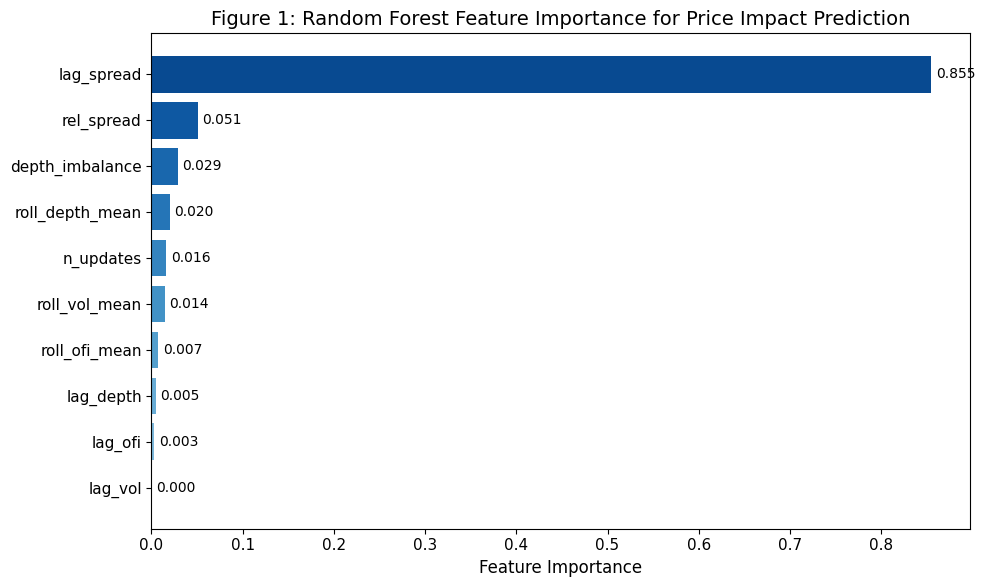

In [17]:
%%py
# FIGURE 1: FEATURE IMPORTANCE BAR CHART

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(importance_df)))
bars = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors[::-1])

ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Figure 1: Random Forest Feature Importance for Price Impact Prediction', fontsize=14)
ax.invert_yaxis()

for bar, val in zip(bars, importance_df['Importance']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

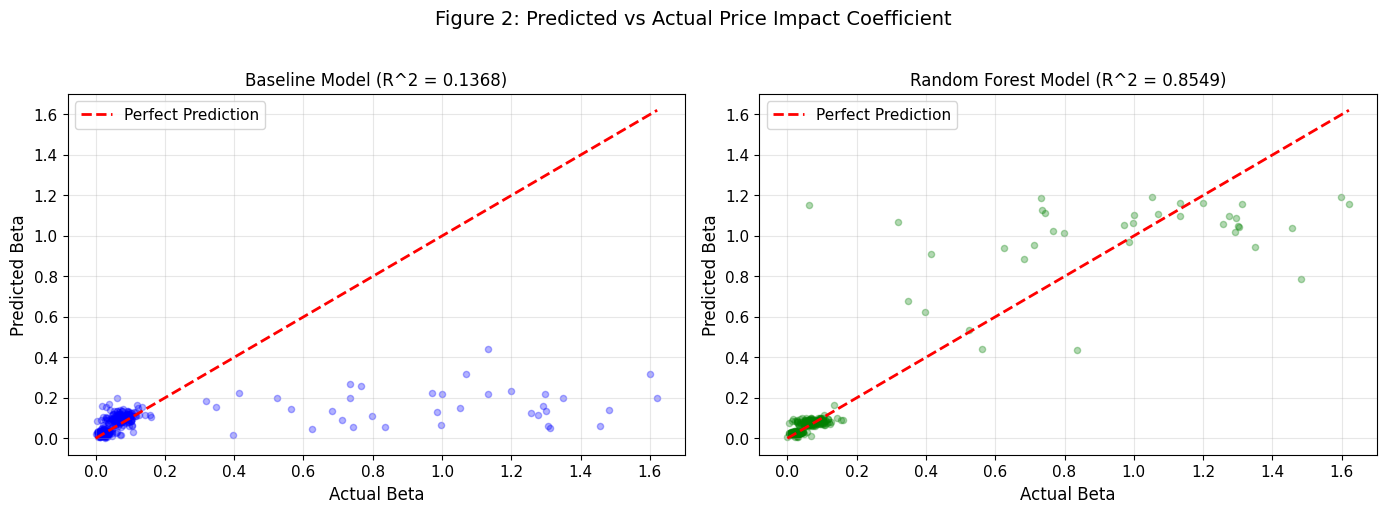

In [18]:
%%py
# FIGURE 2: PREDICTED VS ACTUAL SCATTER PLOT

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Baseline Model
ax1 = axes[0]
ax1.scatter(y_test, y_pred_baseline, alpha=0.3, s=20, c='blue')
lims = [min(y_test.min(), y_pred_baseline.min()), max(y_test.max(), y_pred_baseline.max())]
ax1.plot(lims, lims, 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Beta', fontsize=12)
ax1.set_ylabel('Predicted Beta', fontsize=12)
ax1.set_title(f'Baseline Model (R^2 = {r2_baseline:.4f})', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Random Forest Model
ax2 = axes[1]
ax2.scatter(y_test, y_pred_rf_test, alpha=0.3, s=20, c='green')
lims = [min(y_test.min(), y_pred_rf_test.min()), max(y_test.max(), y_pred_rf_test.max())]
ax2.plot(lims, lims, 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Beta', fontsize=12)
ax2.set_ylabel('Predicted Beta', fontsize=12)
ax2.set_title(f'Random Forest Model (R^2 = {r2_rf:.4f})', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Figure 2: Predicted vs Actual Price Impact Coefficient', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

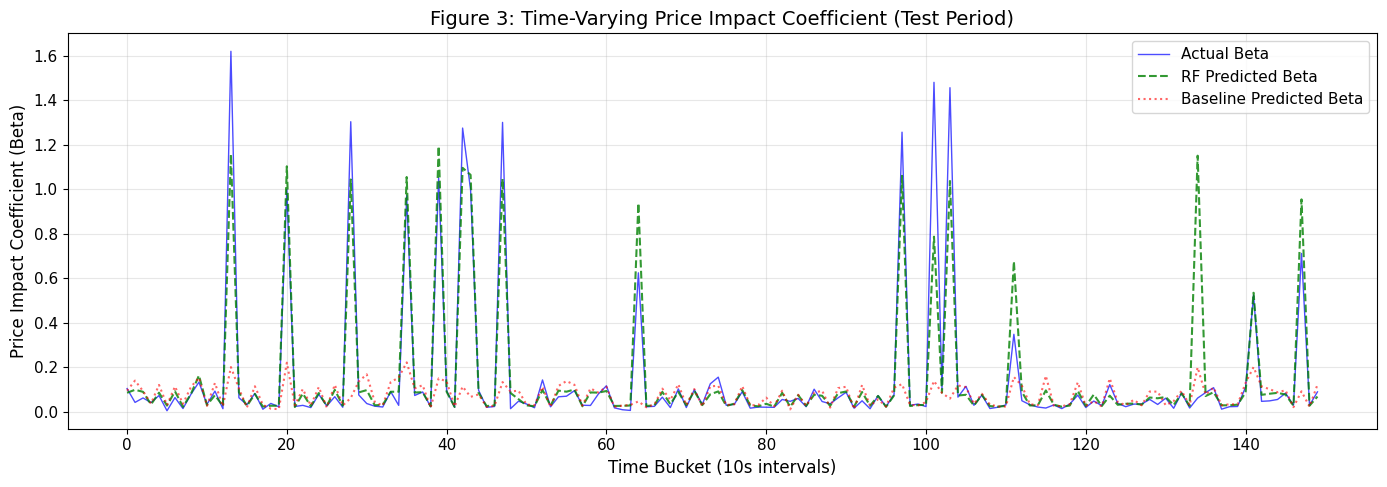

In [19]:
%%py
# FIGURE 3: TIME SERIES OF BETA

n_plot = min(150, len(y_test))
idx = range(n_plot)

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(idx, y_test[:n_plot], 'b-', alpha=0.7, linewidth=1, label='Actual Beta')
ax.plot(idx, y_pred_rf_test[:n_plot], 'g--', alpha=0.8, linewidth=1.5, label='RF Predicted Beta')
ax.plot(idx, y_pred_baseline[:n_plot], 'r:', alpha=0.6, linewidth=1.5, label='Baseline Predicted Beta')

ax.set_xlabel('Time Bucket (10s intervals)', fontsize=12)
ax.set_ylabel('Price Impact Coefficient (Beta)', fontsize=12)
ax.set_title('Figure 3: Time-Varying Price Impact Coefficient (Test Period)', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Market Impact Implications

### Trading Strategy Implications

Our findings have direct implications for **optimal execution**:

The price impact of an order of size $Q$ can be estimated as:
$$\text{Impact}(Q) = \hat{\beta} \cdot Q$$

where $\hat{\beta}$ is our predicted price impact coefficient.

**Key insight:** Using the Random Forest model to dynamically estimate $\beta$ allows traders to:
1. **Schedule orders** during periods of predicted low impact
2. **Adjust execution urgency** based on market conditions
3. **Estimate transaction costs** more accurately

In [20]:
%%py
# MARKET IMPACT ANALYSIS

order_size = 10000  # shares

impact_baseline = y_pred_baseline * order_size
impact_rf = y_pred_rf_test * order_size

print("MARKET IMPACT ESTIMATION ANALYSIS")
print(f"Order Size: {order_size:,} shares")
print("=" * 50)

print(f"\nExpected Price Impact (in price units x 100):")
print(f"Baseline Model Mean:  {np.mean(impact_baseline):.4f}")
print(f"RF Model Mean:        {np.mean(impact_rf):.4f}")
print(f"\nPrice Impact Volatility:")
print(f"Baseline Model Std:   {np.std(impact_baseline):.4f}")
print(f"RF Model Std:         {np.std(impact_rf):.4f}")

MARKET IMPACT ESTIMATION ANALYSIS
Order Size: 10,000 shares

Expected Price Impact (in price units x 100):
Baseline Model Mean:  686.0343
RF Model Mean:        1410.1162

Price Impact Volatility:
Baseline Model Std:   578.0926
RF Model Std:         2868.5863


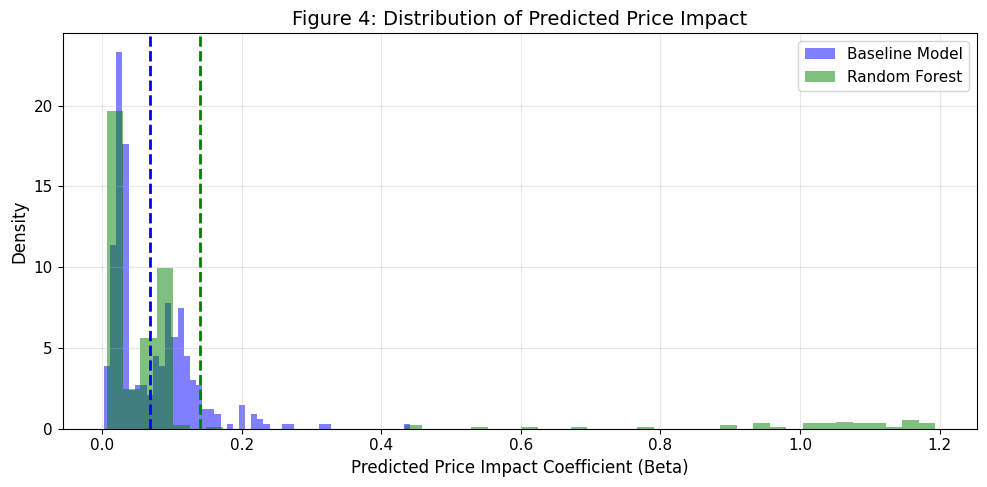

In [21]:
%%py
# FIGURE 4: DISTRIBUTION OF PREDICTED PRICE IMPACT

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(y_pred_baseline, bins=50, alpha=0.5, label='Baseline Model', color='blue', density=True)
ax.hist(y_pred_rf_test, bins=50, alpha=0.5, label='Random Forest', color='green', density=True)

ax.axvline(np.mean(y_pred_baseline), color='blue', linestyle='--', linewidth=2)
ax.axvline(np.mean(y_pred_rf_test), color='green', linestyle='--', linewidth=2)

ax.set_xlabel('Predicted Price Impact Coefficient (Beta)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Figure 4: Distribution of Predicted Price Impact', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
%%py
# PROFITABILITY / EXECUTION TIMING ANALYSIS

threshold = np.percentile(y_pred_rf_test, 25)
optimal_times = y_pred_rf_test <= threshold

avg_impact_optimal = np.mean(y_test[optimal_times])
avg_impact_random = np.mean(y_test)
cost_savings = (avg_impact_random - avg_impact_optimal) / abs(avg_impact_random) * 100 if avg_impact_random != 0 else 0

print("EXECUTION TIMING ANALYSIS")
print("=" * 50)
print(f"\nStrategy: Execute when RF predicts low impact (bottom 25%)")
print(f"\nActual average impact:")
print(f"Optimal times:   {avg_impact_optimal:.6f}")
print(f"Random times:   {avg_impact_random:.6f}")
print(f"\nPotential cost reduction: {cost_savings:.1f}%")

EXECUTION TIMING ANALYSIS

Strategy: Execute when RF predicts low impact (bottom 25%)

Actual average impact:
Optimal times:   0.022987
Random times:   0.133743

Potential cost reduction: 82.8%


In [23]:
%%py
# FINAL SUMMARY

print("FINAL PROJECT SUMMARY")
print("=" * 60)
print(f"\nData:")
print(f"Symbols: {list(df['sym'].unique())}")
print(f"Period: February 3, 2020")
print(f"Bucket: 10 seconds")
print(f"Observations: {len(df_model):,}")

print(f"\nModel Performance (Out-of-Sample R^2):")
print(f"Baseline (Cont et al.): {r2_baseline:.4f}")
print(f"Random Forest:          {r2_rf:.4f}")

print(f"\nTop 3 Most Important Features:")
for _, row in importance_df.head(3).iterrows():
    print(f"{row['Rank']}. {row['Feature']}: {row['Importance']:.4f}")

FINAL PROJECT SUMMARY

Data:
Symbols: ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'NVDA', 'TSLA']
Period: February 3, 2020
Bucket: 10 seconds
Observations: 1,270

Model Performance (Out-of-Sample R^2):
Baseline (Cont et al.): 0.1368
Random Forest:          0.8549

Top 3 Most Important Features:
1. lag_spread: 0.8548
2. rel_spread: 0.0510
3. depth_imbalance: 0.0287
